In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!nvidia-smi

Wed Jun  8 20:59:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 76% 20.0M/26.4M [00:00<00:00, 91.8MB/s]
100% 26.4M/26.4M [00:00<00:00, 115MB/s] 


In [7]:
!unzip entity-annotated-corpus.zip

Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


In [8]:
import os
import time
import warnings
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from collections import Counter
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [9]:
%matplotlib inline
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [10]:
dataset_file = "ner_dataset.csv"

In [11]:
ner_df = pd.read_csv(dataset_file, encoding="latin1", error_bad_lines=False)
ner_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [12]:
# check missing value percentage in [Word, POS, Tag]
missing_percentage = ner_df.isnull().sum() / len(ner_df)
missing_value_df = pd.DataFrame({'column_name': ner_df.columns,
                                 'percent_missing': missing_percentage})
missing_value_df

,column_name,percent_missing
Sentence #,Sentence #,0.954263
Word,Word,0.000000
POS,POS,0.000000
Tag,Tag,0.000000


There is no missing values in the required columns.

In [13]:
df = ner_df.copy()

In [14]:
# forward fill the sentence numbers
df.ffill(axis=0, inplace=True)
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [15]:
# shape of dataframe
df.shape

(1048575, 4)

In [16]:
# List of entities in the dataset
tags = list(df.Tag.unique())
print(tags)

['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


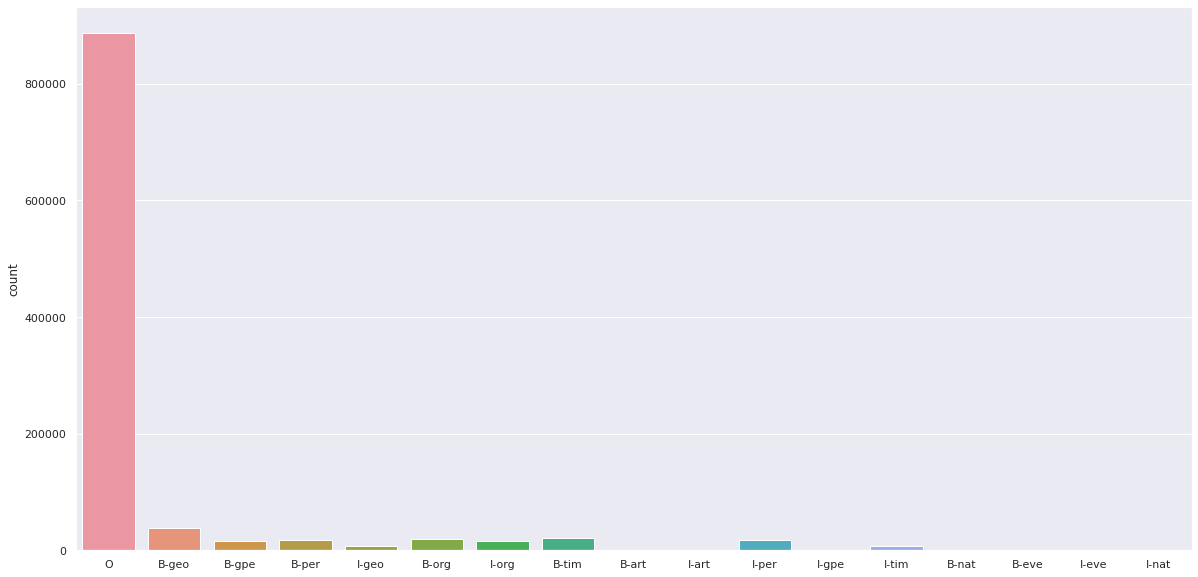

In [17]:
# draw the count of each tag
sns.countplot(df.Tag.values)

In [18]:
num_tags = len(tags)

In [19]:
# convert tags to numeric
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for idx, tag in enumerate(tags)}
print(tag2idx)

{'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8, 'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}


In [20]:
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
group = df.groupby("Sentence #").apply(agg_func)
sentences = [s for s in group]

In [21]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [22]:
# total number of sentences
len(sentences)

47959

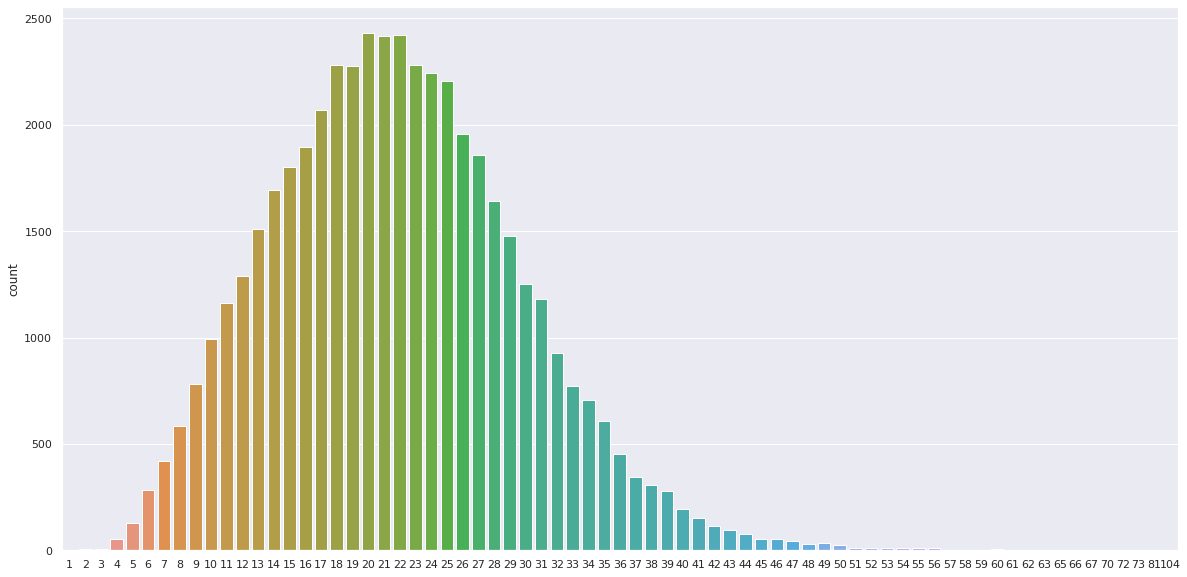

In [23]:
# sentence length distribution
sent_lengths = [len(s) for s in sentences]
sns.countplot(sent_lengths)

In [24]:
# maximum and minimum sentence length
max_sent_len = max(sent_lengths)
min_sent_len = min(sent_lengths)
print(f"Maxium sentence length is {max_sent_len} and Minimum sentence length is {min_sent_len}")

Maxium sentence length is 104 and Minimum sentence length is 1


In [25]:
train_data, valid_data = train_test_split(sentences, test_size=0.3, random_state=42)
valid_data, test_data = train_test_split(valid_data, test_size=0.5, random_state=42)

print(f"Training dataset length: {len(train_data)}")
print(f"Validation dataset length: {len(valid_data)}")
print(f"Testing dataset length: {len(test_data)}")

Training dataset length: 33571
Validation dataset length: 7194
Testing dataset length: 7194


In [26]:
import json

In [27]:
class Vocab(object):
    """ Create the vocabulary of words/tokens """
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.vocab = None
    
    def __len__(self):
        return len(self.word2idx)

    def __str__(self):
        return f"<Vocab(vocab_size={len(self)})>"

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
        
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx["<unk>"]
        return self.word2idx[word]

    def build_vocab(self, sentences, threshold=5):
        counter = Counter()
        for i, sent in enumerate(sentences):
            tokens = []
            for word, _, _ in sent:
                tokens.append(word)
            counter.update(tokens)
        
        words = [word for word, count in counter.items() if count >= threshold]

        self.vocab = Vocab()
        self.vocab.add_word("<pad>")
        self.vocab.add_word("<start>")
        self.vocab.add_word("<end>")
        self.vocab.add_word("<unk>")

        for i, word in enumerate(words):
            self.vocab.add_word(word)
        return self.vocab
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "word2idx": self.word2idx,
                "idx2word": self.idx2word,
                "vocab": self.vocab
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [28]:
words_vocab = Vocab().build_vocab(train_data)

In [29]:
words_vocab("from")

26

In [30]:
MAX_SEQ_LEN = 100

In [31]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, max_len):
        self.sentences = sentences
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        tokens, tags = [], []

        for word, _, tag in sentence:
            tokens.append(words_vocab(word))
            tags.append(tag2idx[tag])
        
        return torch.LongTensor(tokens), torch.LongTensor(tags)
    
    def collate_fn(self, data):
        data.sort(key=lambda x:len(x[0]), reverse=True)
        sentences, tags = zip(*data)

        sent_lengths = [len(sent) for sent in sentences]
        inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
        labels = torch.zeros(len(sentences), max(sent_lengths)).long()

        for i, (sent, label) in enumerate(zip(sentences, tags)):
            end = sent_lengths[i]
            inputs[i, :end] = sent[:end]
            labels[i, :end] = label[:end]
        return inputs, labels, sent_lengths

    def create_dataloader(self, batch_size, shuffle=False):
        return data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, pin_memory=True)

In [32]:
train_dataset = NERDataset(train_data, MAX_SEQ_LEN)
valid_dataset = NERDataset(valid_data, MAX_SEQ_LEN)
test_dataset = NERDataset(test_data, MAX_SEQ_LEN)

In [33]:
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {valid_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Datasets:
  Train dataset:<__main__.NERDataset object at 0x7f3de4002690>
  Val dataset: <__main__.NERDataset object at 0x7f3de4002150>
  Test dataset: <__main__.NERDataset object at 0x7f3de40022d0>
Sample point:
  X: tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  5, 14, 15, 16, 17, 18, 19])
  y: tensor([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [34]:
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
valid_dataloader = valid_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y, _ = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 48]
  y: [64, 48]
Sample point:
  X: tensor([528, 529, 530, 279, 531, 296, 532,  32,  12, 533, 534, 535,  93,  94,
         41,   3,  62,  12, 536,  23,  12,  43,  26, 155, 537,  32,  12, 538,
        539,  23, 540, 537,  32, 541,  23, 542, 543,  32,   3, 544,  26, 542,
        545,  32,  37, 546, 547,  19])
  y: tensor([0, 0, 0, 1, 4, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [35]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 145 kB 65.9 MB/s 
     |████████████████████████████████| 181 kB 69.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a58da98c2c8f6cf00d44a74bc08c239be3ff79131bb64de38050936f14d72256
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [36]:
import wandb

# wandb.init(project="NER Project", entity="alokpadhi")

wandb: Currently logged in as: alokpadhi. Use `wandb login --relogin` to force relogin


In [37]:
# Save label dicts
def save_label(fp):
    with open(fp, "w") as fp:
        contents = {
            "tag2idx": tag2idx,
            "idx2tag": idx2tag,
            }
        json.dump(contents, fp, indent=4, sort_keys=False)

In [39]:
!mkdir artifact_store

In [40]:
save_label("/content/artifact_store/save_tags.json")

In [41]:
# save vocabulary
Vocab().save("/content/artifact_store/vocab_artifact.json")

In [42]:
data_artifact_filepath = "/content/artifact_store"

In [43]:
# wandb.log_artifact(data_artifact_filepath, name='data_artifacts', type='my_dataset') 

wandb: Adding directory to artifact (/content/artifact_store)... Done. 0.1s


In [44]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, tag_vocab_size, dropout=0.1):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hid_dim*2, tag_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, sentences, lengths):
        # sentences: [batch_size, seq_len]
        embed = self.embedding(sentences)
        embed = self.dropout(embed)

        packed_embed = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True)
        packed_output, _ = self.lstm(packed_embed)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        combined = torch.cat((outputs[:,:, :self.hid_dim], outputs[:,:,self.hid_dim:]), dim=-1)
        combined = self.dropout(combined)

        logits = self.fc(combined)

        return logits

In [45]:
config = dict(
    vocab_size=len(words_vocab),
    emb_dim=50,
    hid_dim=100,
    tag_vocab_size=num_tags,
    learning_rate=0.01,
    epochs=10,
    batch_size=batch_size,
    dataset="NER",
    architecture="BiLSTM"
)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
def make(config):
    # Make the model
    model = BiLSTM(config.vocab_size, config.emb_dim, config.hid_dim, config.tag_vocab_size).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, criterion, optimizer

In [48]:
def categorical_accuracy(predictions, y, tag_pad_idx=None):
    max_preds = predictions.argmax(dim=1,keepdim=True)
    max_preds = max_preds.squeeze(1)
    correct = max_preds.eq(y)
    accuracy = correct.sum().item()/(predictions.shape[0] * 1.0)
    return accuracy

In [58]:
def train_batch(model, iterator, criterion, optimizer, tag_pad_idx,clip):
    model.train()

    epoch_loss = 0
    epoch_acc = 0

    train_example_ct = 0  # number of examples seen
    train_batch_ct = 0


    for batch in iterator:
        sentences = batch[0].to(device)
        tags = batch[1].to(device)
        seq_lengths = batch[2]

        optimizer.zero_grad()

        logits = model(sentences, seq_lengths)

        train_example_ct +=  len(sentences)
        train_batch_ct += 1

        packed_logits = nn.utils.rnn.pack_padded_sequence(logits, seq_lengths, batch_first=True)[0]
        packed_tags = nn.utils.rnn.pack_padded_sequence(tags, seq_lengths, batch_first=True)[0]
        loss = criterion(packed_logits, packed_tags)

        acc = categorical_accuracy(packed_logits, packed_tags)

        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

        if ((train_batch_ct + 1) % 25) == 0:
            print(f"Training Loss after " + str(train_example_ct).zfill(5) + f" examples: {loss:.3f}")
            wandb.log({"train_loss": loss, "train_accuracy": acc}, step=train_example_ct)

    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [59]:
def test(model, iterator, criterion, tag_pad_idx):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    valid_example_ct = 0  # number of examples seen
    valid_batch_ct = 0

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].to(device)
            tags = batch[1].to(device)
            seq_lengths = batch[2]

            logits = model(sentences, seq_lengths)
            
            valid_example_ct +=  len(sentences)
            valid_batch_ct += 1
            
            packed_logits = nn.utils.rnn.pack_padded_sequence(logits, seq_lengths, batch_first=True)[0]
            packed_tags = nn.utils.rnn.pack_padded_sequence(tags, seq_lengths, batch_first=True)[0]
            loss = criterion(packed_logits, packed_tags)

            acc = categorical_accuracy(packed_logits, packed_tags)

            epoch_loss += loss.item()
            epoch_acc += acc

            # Report metrics every 25th batch
            if ((valid_batch_ct + 1) % 25) == 0:
                print(f"Loss after (validating)" + str(valid_example_ct).zfill(5) + f" examples: {loss:.3f}")
                wandb.log({"valid_loss": loss, "valid_accuracy": acc}, step=valid_example_ct)

    return epoch_loss / len(iterator), epoch_acc/len(iterator)



In [60]:
def train(model, criterion, optimizer, config, tag_pad_idx=0, clip=2):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    best_valid_loss = float("inf")

    for epoch in range(config.epochs):
        train_loss, train_acc = train_batch(model, train_dataloader, criterion, optimizer, tag_pad_idx, clip)
        valid_loss, valid_acc = test(model, valid_dataloader, criterion, tag_pad_idx)

        wandb.log({"train_epoch_loss":train_loss, "valid_epoch_loss":valid_loss, "train_epoch_acc":train_acc, "valid_epoch_acc":valid_acc, "epoch":epoch})

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "bistm_ner_model.pt")

        print(f"Epoch: {epoch+1}")
        print(f"Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}")
        print(f"Valid loss: {valid_loss:.3f} | Valid accuracy: {valid_acc:.3f}")

In [61]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="NER Project", config=hyperparameters) as run:
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      train(model, criterion, optimizer, config)

      trained_model_artifact = wandb.Artifact(
          "BiLSTM",type="model",description="NER baseline model"
      )
      trained_model_artifact.add_file("bistm_ner_model.pt")
      run.log_artifact(trained_model_artifact)
      run.log_artifact(data_artifact_filepath, name='data_artifacts', type='my_dataset') 

    return model

In [62]:
model = model_pipeline(config)

BiLSTM(
  (embedding): Embedding(8954, 50, padding_idx=0)
  (lstm): LSTM(50, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=17, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Training Loss after 01536 examples: 0.652
Training Loss after 03136 examples: 0.437
Training Loss after 04736 examples: 0.310
Training Loss after 06336 examples: 0.318
Training Loss after 07936 examples: 0.257
Training Loss after 09536 examples: 0.248
Training Loss after 11136 examples: 0.191
Training Loss after 12736 examples: 0.199
Training Loss after 14336 examples: 0.183
Training Loss after 15936 examples: 0.156
Training Loss after 17536 examples: 0.131
Training Loss after 19136 examples: 0.184
Training Loss after 20736 examples: 0.184
Training Loss after 22336 examples: 0.149
Training Loss after 23936 examples: 0.174
Training Loss after 25536 examples: 0.144
Training Loss after 27136 examples: 0.133
Training Loss after 28736 examples: 0.126
Training Loss after

wandb: Adding directory to artifact (/content/artifact_store)... Done. 0.1s


Epoch: 10
Train loss: 0.074 | Train accuracy: 0.975
Valid loss: 0.124 | Valid accuracy: 0.966


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▄▅▆▆▆▇▇█▇▆█▇▇████▇
train_epoch_acc,▁▆▆▇▇▇████
train_epoch_loss,█▃▂▂▂▁▁▁▁▁
train_loss,█▅▄▄▃▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁
valid_epoch_acc,▁▆▆███▇▇██
valid_epoch_loss,█▂▂▁▃▄▄▅▆▇
epoch,9
train_accuracy,0.95646
train_epoch_acc,0.97529
train_epoch_loss,0.07443
